# First-Pass Partitioning and Transition Matrix for MCMC Stochastic Parameterization 

The MCMC stochastic parameterization defined below consists of seven different neural networks which are transitioned between for each time step. The neural networks are distinguished by different training data based on quantiles of precipitation. One neural network is trained on all the data points with zero precipitation, one on data above zero but below the 10th percentile precipitation, and so on. A transition matrix is defined based on the the observed transitions between quantiles of precipitation in the training data.

In [1]:
# Load the data and filter to the tropics.
import xarray as xr
import numpy as np
data = "/Users/stewart/projects/uwnet/data/processed/training.nc"
dataset = xr.open_dataset(data)
dataset = dataset.isel(y=list(range(28, 36)))


In [2]:
# Define percentiles of precip to bin on; the lowest percentile is defined by the percentage
# of data points with zero precipitation.
from collections import Counter
precip_values = dataset.Prec.values.ravel()
zero_precip_percentile = (Counter(precip_values)[0] / len(precip_values)) + 0.00001
percentiles = [zero_precip_percentile, .10, .30, .70, .90, 1 - zero_precip_percentile, 1]

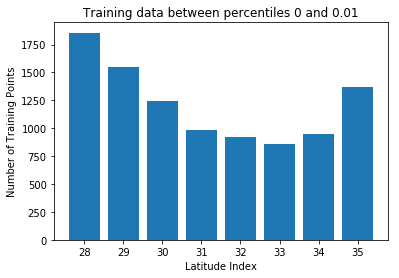

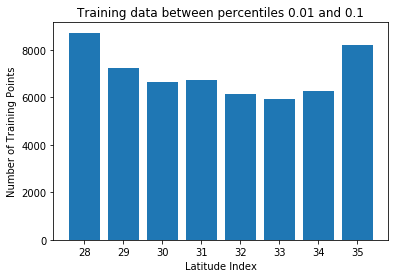

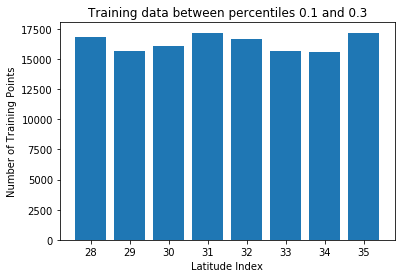

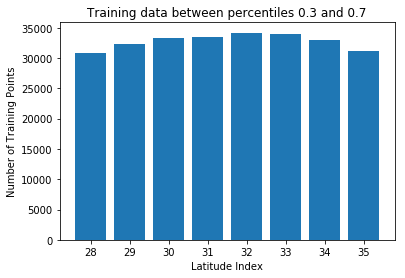

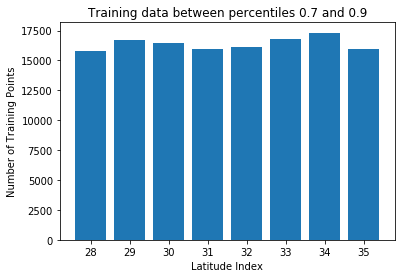

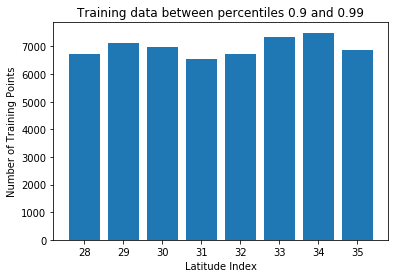

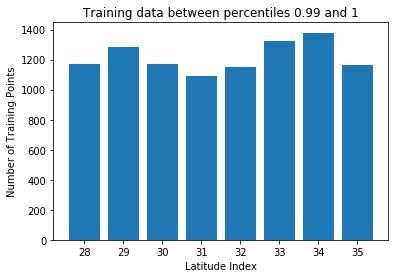

In [4]:
# Plot latitudinal distribution of training points for each bin
%matplotlib inline
from matplotlib import pyplot as plt
latitude_indices = list(range(28, 36))
last_percentile = 0
for percentile in percentiles:
    min_precip = dataset.Prec.quantile(last_percentile)
    max_precip = dataset.Prec.quantile(percentile)
    filtered_ds = dataset.where(dataset.Prec >= min_precip).where(dataset.Prec < max_precip)
    n_training_points_by_latitude = (~np.isnan(filtered_ds.Prec.values)).sum(axis=0).sum(axis=1)
    plt.bar(list(range(len(latitude_indices))), n_training_points_by_latitude, tick_label=latitude_indices)
    plt.xlabel('Latitude Index')
    plt.ylabel('Number of Training Points')
    plt.title(f'Training data between percentiles {round(last_percentile, 2)} and {round(percentile, 2)}')
    last_percentile = percentile
    plt.show()

In [7]:
# Define a transition matrix based on the simulated data.
transition_matrix = []
last_quantile_for_current_state = 0
precip_values = dataset.Prec.values
for current_quantile in percentiles:
    last_percentile = 0
    min_precip = dataset.Prec.quantile(last_quantile_for_current_state)
    max_precip = dataset.Prec.quantile(current_quantile)
    indeces_of_next_time_step = np.argwhere(~np.isnan(
        dataset.where(dataset.Prec >= min_precip).where(dataset.Prec < max_precip).Prec.values))
    indeces_of_next_time_step[:, 2] += 1
    precip_for_next_time_step = np.take(precip_values, indeces_of_next_time_step)[:, 2]
    transition_row = []
    last_quantile = 0
    for quantile in percentiles:
        min_precip = dataset.Prec.quantile(last_quantile).values
        max_precip = dataset.Prec.quantile(quantile).values
        n_values = sum((precip_for_next_time_step >= min_precip) & (precip_for_next_time_step < max_precip))
        transition_row.append(n_values / len(precip_for_next_time_step))
        last_quantile = quantile
    transition_matrix.append(transition_row)
    last_quantile_for_current_state = current_quantile
transition_matrix = np.array(transition_matrix)
print(transition_matrix)

print('\n\nCheck that the columns all sum to 1.')
print(transition_matrix.sum(axis=1))

[[0.03799938 0.12601417 0.30779501 0.36890213 0.10085242 0.05289103
  0.00554586]
 [0.04026954 0.12181222 0.30350006 0.37430778 0.10982276 0.0431549
  0.00713274]
 [0.03933716 0.12532043 0.3062973  0.37583923 0.10756683 0.03822327
  0.00741577]
 [0.03847504 0.12546539 0.30817795 0.37430573 0.10776138 0.03798294
  0.00783157]
 [0.03929901 0.12569427 0.30180359 0.37528992 0.11139679 0.03833771
  0.00817871]
 [0.03969605 0.12376566 0.29389416 0.37670926 0.11693758 0.04017993
  0.00881736]
 [0.03851684 0.12304848 0.293447   0.37880033 0.1125719  0.04550123
  0.00811422]]


Check that the columns all sum to 1.
[1. 1. 1. 1. 1. 1. 1.]


The remaining work consists of training the neural networks on the data defined above and implementing the MCMC process. 